In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
from torchvision.datasets import FGVCAircraft
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

granularity = 'family'

# Create the FGVC Aircraft dataset instance
train_dataset = FGVCAircraft(
    root='./data',
    split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
    annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
    transform=transform,
    download=True
)

# shuffle the train dataset and split into 20% val, 80% train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

# val_dataset = FGVCAircraft(
#     root='./data',
#     split='val',
#     annotation_level='variant',
#     transform=transform,
#     download=True
# )

test_dataset = FGVCAircraft(
    root='./data',
    split='test',
    annotation_level=granularity,
    transform=transform,
    download=True
)

100%|██████████| 2.75G/2.75G [00:24<00:00, 114MB/s]


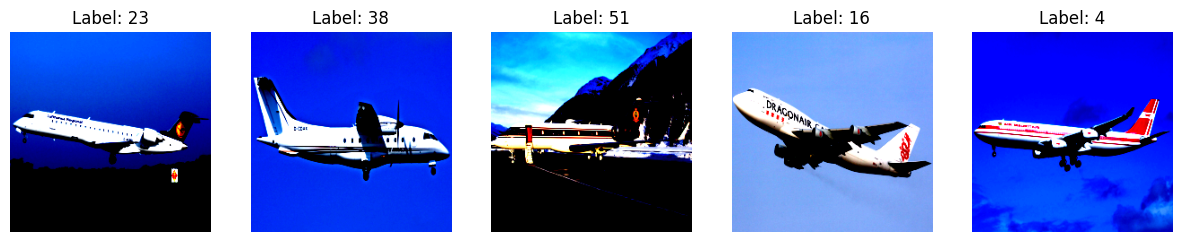

In [4]:
# function to show images
def show_images(train_dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = train_dataset[i]
        image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [5]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if cumulative:
          for i in range((label // 10), 10):
            task_dict[i].append(idx)
        else:
          task_dict[label // 10].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset)
val_task_idxs = group_task_indices(val_dataset, cumulative=True)
test_task_idxs = group_task_indices(test_dataset, cumulative=True)

100%|██████████| 3333/3333 [00:47<00:00, 70.79it/s]


In [6]:
labels_dict = defaultdict(int)
for i in tqdm(train_task_idxs[1], total=len(train_task_idxs)):
    _, label = train_dataset[i]
    labels_dict[label] += 1
print(labels_dict)

1292it [00:17, 71.88it/s]

defaultdict(<class 'int'>, {16: 210, 17: 105, 19: 108, 15: 426, 11: 51, 18: 163, 13: 54, 10: 58, 14: 57, 12: 60})


## Training Code

In [7]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save to checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # save task, trainloss, valloss to file
        if save_file:
            with open(save_file, 'a') as f:
                f.write(f"{task},{epoch + 1},{avg_loss},{val_losses[-1]}\n")

        # early stopping based on patience
        if len(val_losses) > patience and val_losses[-1] >= min(val_losses[:-patience]):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("finished training")
    return train_losses, val_losses

In [8]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [9]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
# )

# create output file for train and val losses

save_dir = 'naive'

for task in range(10):

    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.0015)

    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset, train_task_idxs[task]), batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g
    )
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # create output file for train and val losses
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Train the model on the current task
    train_losses, val_losses = train_net(15, 5, 8, model, optimizer, train_loader, val_loader, task, save_file=os.path.join(save_dir, 'train_val_losses.txt'))

    # Evaluate the model on the test set
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task}: {per_class_acc}")

    # save to text file in save dir
    if not os.path.exists(os.path.join(save_dir, 'accuracies.txt')):
        with open(os.path.join(save_dir, 'accuracies.txt'), 'w') as f:
            f.write("Task,Overall Accuracy,Per-Class Accuracy\n")
    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    # Save the model after training on each task in save dir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Training on task 0...


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Epoch 1, Training Loss: 2.407, Validation Loss: 2.315


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 2, Training Loss: 2.156, Validation Loss: 2.292


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 3, Training Loss: 1.961, Validation Loss: 2.176


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Epoch 4, Training Loss: 1.814, Validation Loss: 2.110


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 5, Training Loss: 1.740, Validation Loss: 2.066


Validating: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Epoch 6, Training Loss: 1.548, Validation Loss: 1.900


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


Epoch 7, Training Loss: 0.688, Validation Loss: 1.699


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Epoch 8, Training Loss: 0.327, Validation Loss: 1.629


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Epoch 9, Training Loss: 0.146, Validation Loss: 1.586


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 10, Training Loss: 0.074, Validation Loss: 1.525


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 11, Training Loss: 0.044, Validation Loss: 1.498


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Epoch 12, Training Loss: 0.031, Validation Loss: 1.506


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Epoch 13, Training Loss: 0.021, Validation Loss: 1.514


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Epoch 14, Training Loss: 0.018, Validation Loss: 1.512


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 15, Training Loss: 0.015, Validation Loss: 1.514
finished training


Testing: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Overall accuracy for task 0: 0.5195
Per-class accuracy for task 0: [0.8787878787878788, 0.8484848484848485, 0.5294117647058824, 0.12121212121212122, 0.5151515151515151, 0.38235294117647056, 0.696969696969697, 0.21212121212121213, 0.29411764705882354, 0.7272727272727273]
Model for task 0 saved as model_task_0.pth
Training on task 1...


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 1, Training Loss: 2.529, Validation Loss: 4.674


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 2, Training Loss: 2.096, Validation Loss: 5.697


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 3, Training Loss: 1.878, Validation Loss: 6.165


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 4, Training Loss: 1.737, Validation Loss: 6.275


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 5, Training Loss: 1.639, Validation Loss: 6.375


Validating: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch 6, Training Loss: 1.479, Validation Loss: 6.827


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 7, Training Loss: 0.620, Validation Loss: 6.484


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 8, Training Loss: 0.303, Validation Loss: 6.153


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch 9, Training Loss: 0.142, Validation Loss: 6.267
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Overall accuracy for task 1: 0.2297
Per-class accuracy for task 1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42424242424242425, 0.4117647058823529, 0.3333333333333333, 0.36363636363636365, 0.4411764705882353, 0.7272727272727273, 0.5757575757575758, 0.23529411764705882, 0.6666666666666666, 0.42424242424242425]
Model for task 1 saved as model_task_1.pth
Training on task 2...


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 1, Training Loss: 2.978, Validation Loss: 7.444


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


Epoch 2, Training Loss: 2.052, Validation Loss: 8.932


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


Epoch 3, Training Loss: 1.748, Validation Loss: 9.524


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


Epoch 4, Training Loss: 1.560, Validation Loss: 9.779


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


Epoch 5, Training Loss: 1.445, Validation Loss: 9.864


Validating: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch 6, Training Loss: 1.269, Validation Loss: 10.688


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


Epoch 7, Training Loss: 0.470, Validation Loss: 9.674


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


Epoch 8, Training Loss: 0.212, Validation Loss: 9.447


Validating: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]


Epoch 9, Training Loss: 0.098, Validation Loss: 9.363
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


Overall accuracy for task 2: 0.2070
Per-class accuracy for task 2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8529411764705882, 0.5757575757575758, 0.48484848484848486, 0.8235294117647058, 0.5454545454545454, 0.5757575757575758, 0.6176470588235294, 0.45454545454545453, 0.5151515151515151, 0.7352941176470589]
Model for task 2 saved as model_task_2.pth
Training on task 3...


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 1, Training Loss: 4.087, Validation Loss: 10.463


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


Epoch 2, Training Loss: 2.012, Validation Loss: 13.063


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 3, Training Loss: 1.599, Validation Loss: 14.094


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


Epoch 4, Training Loss: 1.357, Validation Loss: 14.490


Validating: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 5, Training Loss: 1.242, Validation Loss: 14.631


Validating: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 6, Training Loss: 0.951, Validation Loss: 15.884


Validating: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


Epoch 7, Training Loss: 0.310, Validation Loss: 14.838


Validating: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 8, Training Loss: 0.158, Validation Loss: 14.271


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


Epoch 9, Training Loss: 0.077, Validation Loss: 13.827
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Overall accuracy for task 3: 0.1853
Per-class accuracy for task 3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5454545454545454, 0.6363636363636364, 0.5882352941176471, 0.6666666666666666, 0.8484848484848485, 0.8823529411764706, 1.0, 0.7272727272727273, 0.5882352941176471, 0.9393939393939394]
Model for task 3 saved as model_task_3.pth
Training on task 4...


Validating: 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]


Epoch 1, Training Loss: 5.194, Validation Loss: 12.296


Validating: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 2, Training Loss: 2.095, Validation Loss: 15.133


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


Epoch 3, Training Loss: 1.674, Validation Loss: 16.116


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Epoch 4, Training Loss: 1.409, Validation Loss: 16.596


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Epoch 5, Training Loss: 1.267, Validation Loss: 16.785


Validating: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 6, Training Loss: 1.008, Validation Loss: 17.784


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]


Epoch 7, Training Loss: 0.323, Validation Loss: 16.864


Validating: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s]


Epoch 8, Training Loss: 0.160, Validation Loss: 16.387


Validating: 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 9, Training Loss: 0.098, Validation Loss: 16.434
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


Overall accuracy for task 4: 0.1681
Per-class accuracy for task 4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8787878787878788, 0.8235294117647058, 1.0, 0.9090909090909091, 0.7352941176470589, 0.7272727272727273, 0.6060606060606061, 1.0, 0.7272727272727273, 1.0]
Model for task 4 saved as model_task_4.pth
Training on task 5...


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Epoch 1, Training Loss: 5.523, Validation Loss: 14.164


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Epoch 2, Training Loss: 1.956, Validation Loss: 17.021


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 3, Training Loss: 1.437, Validation Loss: 18.315


Validating: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch 4, Training Loss: 1.140, Validation Loss: 18.629


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.20it/s]


Epoch 5, Training Loss: 0.917, Validation Loss: 18.944


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Epoch 6, Training Loss: 0.693, Validation Loss: 20.158


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


Epoch 7, Training Loss: 0.169, Validation Loss: 18.716


Validating: 100%|██████████| 13/13 [00:10<00:00,  1.21it/s]


Epoch 8, Training Loss: 0.081, Validation Loss: 17.811


Validating: 100%|██████████| 13/13 [00:09<00:00,  1.32it/s]


Epoch 9, Training Loss: 0.034, Validation Loss: 17.600
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]


Overall accuracy for task 5: 0.1450
Per-class accuracy for task 5: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8823529411764706, 0.9090909090909091, 0.7878787878787878, 0.7941176470588235, 0.8787878787878788, 0.6363636363636364, 0.9411764705882353, 1.0, 0.8484848484848485, 1.0]
Model for task 5 saved as model_task_5.pth
Training on task 6...


Validating: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 1, Training Loss: 6.127, Validation Loss: 14.861


Validating: 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Epoch 2, Training Loss: 1.920, Validation Loss: 17.905


Validating: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Epoch 3, Training Loss: 1.363, Validation Loss: 19.276


Validating: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 4, Training Loss: 1.084, Validation Loss: 19.837


Validating: 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Epoch 5, Training Loss: 0.937, Validation Loss: 20.017


Validating: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Epoch 6, Training Loss: 0.764, Validation Loss: 20.710


Validating: 100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Epoch 7, Training Loss: 0.252, Validation Loss: 20.123


Validating: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 8, Training Loss: 0.105, Validation Loss: 19.546


Validating: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Epoch 9, Training Loss: 0.050, Validation Loss: 19.338
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 37/37 [00:29<00:00,  1.26it/s]


Overall accuracy for task 6: 0.1192
Per-class accuracy for task 6: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7878787878787878, 0.9090909090909091, 0.9705882352941176, 0.8484848484848485, 0.9090909090909091, 0.7352941176470589, 0.7878787878787878, 0.9696969696969697, 0.8823529411764706, 0.5454545454545454]
Model for task 6 saved as model_task_6.pth
Training on task 7...


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 1, Training Loss: 6.264, Validation Loss: 16.407


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 2, Training Loss: 1.889, Validation Loss: 19.389


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 3, Training Loss: 1.286, Validation Loss: 20.659


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.27it/s]


Epoch 4, Training Loss: 1.025, Validation Loss: 21.138


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 5, Training Loss: 0.876, Validation Loss: 21.465


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.25it/s]


Epoch 6, Training Loss: 0.675, Validation Loss: 22.322


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 7, Training Loss: 0.198, Validation Loss: 20.772


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


Epoch 8, Training Loss: 0.066, Validation Loss: 20.372


Validating: 100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


Epoch 9, Training Loss: 0.031, Validation Loss: 20.281
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 42/42 [00:34<00:00,  1.22it/s]


Overall accuracy for task 7: 0.1107
Per-class accuracy for task 7: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9393939393939394, 0.9705882352941176, 0.9696969696969697, 0.9393939393939394, 0.8529411764705882, 0.7575757575757576, 0.8484848484848485, 0.8529411764705882, 0.8181818181818182, 0.9090909090909091]
Model for task 7 saved as model_task_7.pth
Training on task 8...


Validating: 100%|██████████| 19/19 [00:15<00:00,  1.19it/s]


Epoch 1, Training Loss: 6.678, Validation Loss: 16.852


Validating: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Epoch 2, Training Loss: 2.001, Validation Loss: 19.504


Validating: 100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


Epoch 3, Training Loss: 1.302, Validation Loss: 20.767


Validating: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Epoch 4, Training Loss: 0.991, Validation Loss: 21.292


Validating: 100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Epoch 5, Training Loss: 0.824, Validation Loss: 21.543


Validating: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


Epoch 6, Training Loss: 0.674, Validation Loss: 22.894


Validating: 100%|██████████| 19/19 [00:14<00:00,  1.30it/s]


Epoch 7, Training Loss: 0.254, Validation Loss: 21.555


Validating: 100%|██████████| 19/19 [00:14<00:00,  1.27it/s]


Epoch 8, Training Loss: 0.103, Validation Loss: 20.795


Validating: 100%|██████████| 19/19 [00:15<00:00,  1.21it/s]


Epoch 9, Training Loss: 0.047, Validation Loss: 20.711
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 47/47 [00:38<00:00,  1.22it/s]


Overall accuracy for task 8: 0.0857
Per-class accuracy for task 8: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7058823529411765, 0.7272727272727273, 0.9696969696969697, 0.9705882352941176, 0.7272727272727273, 0.8181818181818182, 0.5882352941176471, 0.6060606060606061, 0.6666666666666666, 0.9117647058823529]
Model for task 8 saved as model_task_8.pth
Training on task 9...


Validating: 100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch 1, Training Loss: 6.463, Validation Loss: 17.600


Validating: 100%|██████████| 21/21 [00:16<00:00,  1.29it/s]


Epoch 2, Training Loss: 1.981, Validation Loss: 20.022


Validating: 100%|██████████| 21/21 [00:16<00:00,  1.27it/s]


Epoch 3, Training Loss: 1.373, Validation Loss: 21.229


Validating: 100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Epoch 4, Training Loss: 0.956, Validation Loss: 21.849


Validating: 100%|██████████| 21/21 [00:17<00:00,  1.21it/s]


Epoch 5, Training Loss: 0.763, Validation Loss: 21.906


Validating: 100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch 6, Training Loss: 0.501, Validation Loss: 23.049


Validating: 100%|██████████| 21/21 [00:17<00:00,  1.19it/s]


Epoch 7, Training Loss: 0.143, Validation Loss: 21.974


Validating: 100%|██████████| 21/21 [00:17<00:00,  1.22it/s]


Epoch 8, Training Loss: 0.090, Validation Loss: 21.609


Validating: 100%|██████████| 21/21 [00:16<00:00,  1.25it/s]


Epoch 9, Training Loss: 0.060, Validation Loss: 21.019
Early stopping at epoch 9
finished training


Testing: 100%|██████████| 53/53 [00:42<00:00,  1.24it/s]


Overall accuracy for task 9: 0.0897
Per-class accuracy for task 9: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9090909090909091, 0.696969696969697, 0.9705882352941176, 0.8181818181818182, 0.8787878787878788, 0.9705882352941176, 0.9696969696969697, 0.9696969696969697, 0.8529411764705882, 0.9393939393939394]
Model for task 9 saved as model_task_9.pth


In [ ]:
# zip the naive folder
import shutil
shutil.make_archive('naive', 'zip', 'naive')

'/content/naive.zip'

## Replay Code

In [11]:
def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [15]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

# --- Modify your main loop ---
save_dir = 'replay' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(5):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} replay samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...
Task 0: Training only with 951 current samples.
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


Task 0, Epoch 1, Train Loss: 2.2253, Val Loss (Cumulative): 2.1168


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


Task 0, Epoch 2, Train Loss: 1.9764, Val Loss (Cumulative): 1.8568


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it]


Task 0, Epoch 3, Train Loss: 1.7695, Val Loss (Cumulative): 1.7209


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


Task 0, Epoch 4, Train Loss: 1.6038, Val Loss (Cumulative): 1.6396


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


Task 0, Epoch 5, Train Loss: 1.5069, Val Loss (Cumulative): 1.5559


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Task 0, Epoch 6, Train Loss: 1.3756, Val Loss (Cumulative): 1.5139


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


Task 0, Epoch 7, Train Loss: 1.2889, Val Loss (Cumulative): 1.4417


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


Task 0, Epoch 8, Train Loss: 1.2133, Val Loss (Cumulative): 1.4061


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


Task 0, Epoch 9, Train Loss: 1.1455, Val Loss (Cumulative): 1.3716


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


Task 0, Epoch 10, Train Loss: 1.0936, Val Loss (Cumulative): 1.3252


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Task 0, Epoch 11, Train Loss: 1.0461, Val Loss (Cumulative): 1.3166


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


Task 0, Epoch 12, Train Loss: 0.9990, Val Loss (Cumulative): 1.2851


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Task 0, Epoch 13, Train Loss: 0.9688, Val Loss (Cumulative): 1.2728


Validating: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


Task 0, Epoch 14, Train Loss: 0.9319, Val Loss (Cumulative): 1.2535


Validating: 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]


Task 0, Epoch 15, Train Loss: 0.8875, Val Loss (Cumulative): 1.2342
Finished training task 0
Sampling 20 examples from task 0 for memory buffer...
Memory buffer size: 20 / 1000


Testing: 100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


Overall accuracy for task 0 (on classes 0-9): 0.6433
Model for task 0 saved as model_task_0.pth
Training on task 1...
Task 1: Training with 1292 current samples and 20 replay samples.
Starting training for Task 1. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


Task 1, Epoch 1, Train Loss: 2.2271, Val Loss (Cumulative): 2.3815


Validating: 100%|██████████| 3/3 [00:06<00:00,  2.32s/it]


Task 1, Epoch 2, Train Loss: 1.0079, Val Loss (Cumulative): 2.4198


Validating: 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]


Task 1, Epoch 3, Train Loss: 0.4796, Val Loss (Cumulative): 2.2295


Validating: 100%|██████████| 3/3 [00:07<00:00,  2.41s/it]


Task 1, Epoch 4, Train Loss: 0.2242, Val Loss (Cumulative): 2.2531


Validating: 100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


Task 1, Epoch 5, Train Loss: 0.1056, Val Loss (Cumulative): 2.3218
Unfreezing backbone at epoch 5 for task 1


Validating: 100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


Task 1, Epoch 6, Train Loss: 0.0565, Val Loss (Cumulative): 2.3691


Validating: 100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


Task 1, Epoch 7, Train Loss: 0.0323, Val Loss (Cumulative): 2.3555


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.69s/it]


Task 1, Epoch 8, Train Loss: 0.0221, Val Loss (Cumulative): 2.3505
Early stopping triggered at epoch 8 for task 1. Best Val Loss: 2.2295
Finished training task 1
Sampling 20 examples from task 1 for memory buffer...
Memory buffer size: 40 / 1000


Testing: 100%|██████████| 6/6 [00:17<00:00,  2.93s/it]


Overall accuracy for task 1 (on classes 0-19): 0.4700
Model for task 1 saved as model_task_1.pth
Training on task 2...
Task 2: Training with 615 current samples and 40 replay samples.
Starting training for Task 2. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 3/3 [00:09<00:00,  3.30s/it]


Task 2, Epoch 1, Train Loss: 3.3384, Val Loss (Cumulative): 2.7483


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.99s/it]


Task 2, Epoch 2, Train Loss: 1.7771, Val Loss (Cumulative): 2.7247


Validating: 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


Task 2, Epoch 3, Train Loss: 1.0363, Val Loss (Cumulative): 2.8201


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]


Task 2, Epoch 4, Train Loss: 0.6149, Val Loss (Cumulative): 2.9395


Validating: 100%|██████████| 3/3 [00:09<00:00,  3.26s/it]


Task 2, Epoch 5, Train Loss: 0.3378, Val Loss (Cumulative): 3.0255
Unfreezing backbone at epoch 5 for task 2


Validating: 100%|██████████| 3/3 [00:08<00:00,  2.97s/it]


Task 2, Epoch 6, Train Loss: 0.2309, Val Loss (Cumulative): 3.0791


Validating: 100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


Task 2, Epoch 7, Train Loss: 0.1519, Val Loss (Cumulative): 3.0452
Early stopping triggered at epoch 7 for task 2. Best Val Loss: 2.7247
Finished training task 2
Sampling 20 examples from task 2 for memory buffer...
Memory buffer size: 60 / 1000


Testing: 100%|██████████| 8/8 [00:23<00:00,  2.89s/it]


Overall accuracy for task 2 (on classes 0-29): 0.3078
Model for task 2 saved as model_task_2.pth
Training on task 3...
Task 3: Training with 600 current samples and 60 replay samples.
Starting training for Task 3. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


Task 3, Epoch 1, Train Loss: 3.2813, Val Loss (Cumulative): 3.4336


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Task 3, Epoch 2, Train Loss: 1.6845, Val Loss (Cumulative): 3.2309


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Task 3, Epoch 3, Train Loss: 0.8707, Val Loss (Cumulative): 3.2892


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


Task 3, Epoch 4, Train Loss: 0.4811, Val Loss (Cumulative): 3.4305


Validating: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


Task 3, Epoch 5, Train Loss: 0.2579, Val Loss (Cumulative): 3.5428
Unfreezing backbone at epoch 5 for task 3


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


Task 3, Epoch 6, Train Loss: 0.1461, Val Loss (Cumulative): 3.5715


Validating: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Task 3, Epoch 7, Train Loss: 0.0984, Val Loss (Cumulative): 3.5756
Early stopping triggered at epoch 7 for task 3. Best Val Loss: 3.2309
Finished training task 3
Sampling 20 examples from task 3 for memory buffer...
Memory buffer size: 80 / 1000


Testing: 100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


Overall accuracy for task 3 (on classes 0-39): 0.2493
Model for task 3 saved as model_task_3.pth
Training on task 4...
Task 4: Training with 708 current samples and 80 replay samples.
Starting training for Task 4. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.wei

Validating: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


Task 4, Epoch 1, Train Loss: 3.2243, Val Loss (Cumulative): 4.1135


Validating: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Task 4, Epoch 2, Train Loss: 1.5103, Val Loss (Cumulative): 4.3247


Validating: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Task 4, Epoch 3, Train Loss: 0.7255, Val Loss (Cumulative): 4.3578


Validating: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Task 4, Epoch 4, Train Loss: 0.3983, Val Loss (Cumulative): 4.2055


Validating: 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]


Task 4, Epoch 5, Train Loss: 0.2119, Val Loss (Cumulative): 4.1209
Unfreezing backbone at epoch 5 for task 4


Validating: 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


Task 4, Epoch 6, Train Loss: 0.1202, Val Loss (Cumulative): 4.1499
Early stopping triggered at epoch 6 for task 4. Best Val Loss: 4.1135
Finished training task 4
Sampling 20 examples from task 4 for memory buffer...
Memory buffer size: 100 / 1000


Testing: 100%|██████████| 11/11 [00:32<00:00,  2.93s/it]

Overall accuracy for task 4 (on classes 0-49): 0.1935
Model for task 4 saved as model_task_4.pth


In [18]:
import shutil
shutil.make_archive('replay', 'zip', 'replay')

'/content/replay.zip'

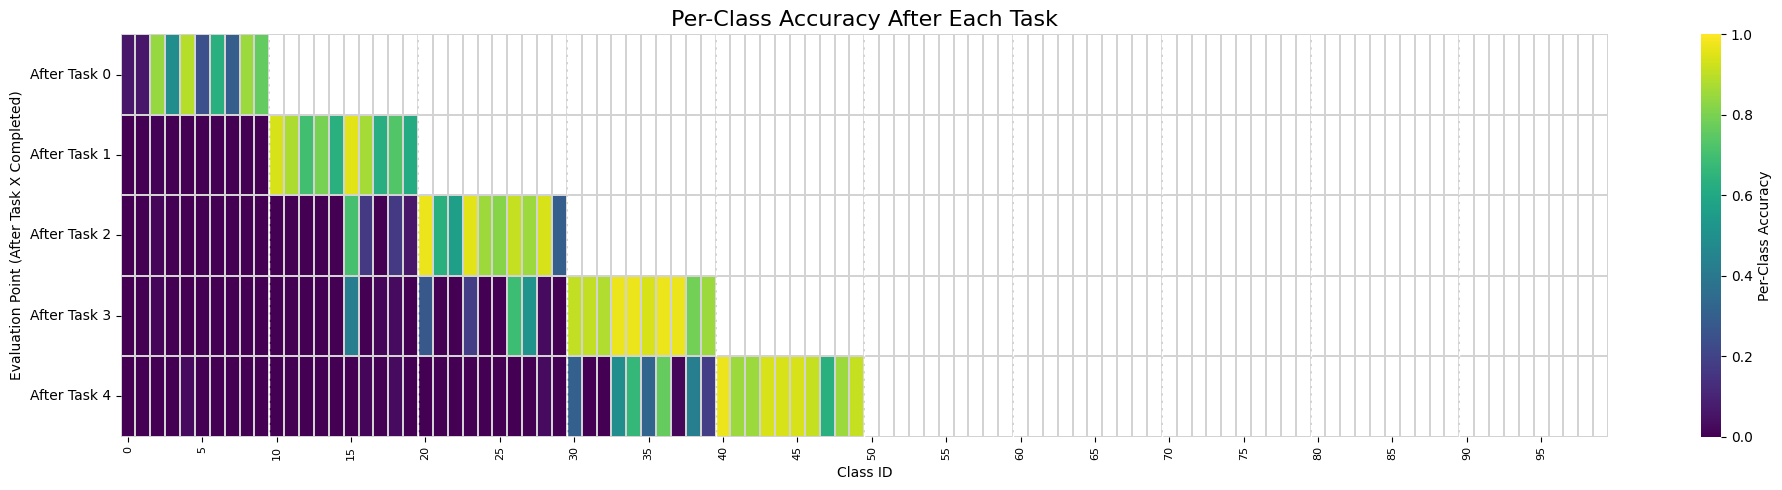

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast # To safely evaluate the string list literal
import os # To check if file exists

# --- Configuration ---
accuracy_file_path = 'replay/accuracies.txt' # Make sure this file exists
num_total_classes = 100 # FGVC Aircraft has 100 classes
num_classes_per_task = 10

# --- Data Loading and Manual Parsing ---
parsed_data = {}

# Check if the file exists before trying to read
if not os.path.exists(accuracy_file_path):
    print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
    print("Please make sure you have saved the data into a file named 'accuracies.txt' in the correct directory.")
    exit()

try:
    with open(accuracy_file_path, 'r') as f:
        header = f.readline().strip() # Read and ignore the header line
        if not header.startswith("Task,Overall Accuracy,Per-Class Accuracy"):
             print("Warning: Header doesn't exactly match expected format, but proceeding.")

        for line_num, line in enumerate(f, start=2): # Start line count from 2 for error messages
            line = line.strip()
            if not line: # Skip empty lines
                continue

            try:
                # Find the first comma to isolate Task ID
                first_comma_idx = line.find(',')
                if first_comma_idx == -1:
                    raise ValueError("Missing first comma separating Task ID")
                task_id_str = line[:first_comma_idx]
                task_id = int(task_id_str)

                # Find the second comma to isolate Overall Accuracy (and the start of the list)
                # Start searching *after* the first comma
                second_comma_idx = line.find(',', first_comma_idx + 1)
                if second_comma_idx == -1:
                     raise ValueError("Missing second comma separating Overall Accuracy")

                # The rest of the line, starting after the second comma, is the list string
                list_str = line[second_comma_idx + 1:]

                # Safely evaluate the string list using ast.literal_eval
                per_class_acc_list = ast.literal_eval(list_str)

                # Validate that it's actually a list
                if not isinstance(per_class_acc_list, list):
                    raise TypeError(f"Parsed data for 'Per-Class Accuracy' is not a list (type: {type(per_class_acc_list)}).")

                # Convert elements to float just in case
                per_class_acc_list = [float(acc) for acc in per_class_acc_list]
                parsed_data[task_id] = per_class_acc_list
                # print(f"Parsed Task {task_id}, found {len(per_class_acc_list)} accuracies.") # Optional print

            except (ValueError, SyntaxError, TypeError, IndexError) as e:
                print(f"Warning: Could not parse line {line_num}. Error: {e}. Line content: '{line}'")
            except Exception as e:
                # Catch any other unexpected errors during parsing of a specific line
                print(f"An unexpected error occurred parsing line {line_num}: {e}")


except FileNotFoundError:
    # This case is handled by the os.path.exists check above, but kept for safety
    print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
    exit()
except Exception as e:
    # Catch errors related to opening or reading the file itself
    print(f"Error reading file '{accuracy_file_path}': {e}")
    exit()

# --- Prepare Data Matrix for Heatmap (Code remains the same) ---
num_tasks_found = len(parsed_data)
if num_tasks_found == 0:
    print("No valid task data parsed. Exiting.")
    exit()

# Create a matrix: rows = tasks, cols = classes
# Initialize with NaN for classes not yet seen/evaluated
acc_matrix = np.full((num_tasks_found, num_total_classes), np.nan)

sorted_task_ids = sorted(parsed_data.keys())

for task_idx, task_id in enumerate(sorted_task_ids):
    accuracies = parsed_data[task_id]
    num_classes_in_task_eval = len(accuracies)
    if num_classes_in_task_eval > num_total_classes:
         print(f"Warning: Task {task_id} reported {num_classes_in_task_eval} accuracies, exceeding total classes {num_total_classes}. Truncating.")
         num_classes_in_task_eval = num_total_classes
         accuracies = accuracies[:num_total_classes]

    # Fill the matrix row for this task up to the number of classes evaluated
    acc_matrix[task_idx, :num_classes_in_task_eval] = accuracies

# --- Plotting the Heatmap (Code remains the same) ---
plt.figure(figsize=(20, max(5, num_tasks_found * 0.7))) # Adjusted size

heatmap = sns.heatmap(
    acc_matrix,
    annot=False,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.2,
    linecolor='lightgrey',
    cbar_kws={'label': 'Per-Class Accuracy'},
    vmin=0.0,
    vmax=1.0
)

plt.xlabel("Class ID")
plt.ylabel("Evaluation Point (After Task X Completed)")
plt.title("Per-Class Accuracy After Each Task", fontsize=16)
plt.xticks(ticks=np.arange(0, num_total_classes, 5) + 0.5, labels=np.arange(0, num_total_classes, 5), rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(num_tasks_found) + 0.5, labels=[f"After Task {t}" for t in sorted_task_ids], rotation=0)

for i in range(num_classes_per_task, num_total_classes, num_classes_per_task):
    plt.axvline(x=i, color='white', linestyle='--', linewidth=1.0)

plt.tight_layout()
plt.show()